In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg  import cholesky, solve_triangular
from scipy.special import logsumexp

In [2]:
def random_choice(X):
    arr = range(len(X))
    idx = np.random.choice(arr)
    return X[idx]

In [3]:
def compute_prec_chol(cov):
    _, p = np.array(cov).shape
    cov_chol = cholesky(cov, lower=True)
    return solve_triangular(cov_chol, np.eye(p), lower=True).T

In [54]:
def compute_mahalanobis(X, mu, prc_chol):
    y = np.dot(X, prc_chol) - np.dot(mu, prc_chol)
    return np.sum(np.square(y), axis=1)

In [168]:
np.random.seed(0)

In [169]:
X1 = np.c_[np.random.randn(200), np.random.randn(200)]
X2 = np.c_[np.random.randn(200)*.5 + 1, np.random.randn(200)*.5 + 1]
X  = np.r_[X1, X2]
X[:5]

array([[ 1.76405235, -0.36918184],
       [ 0.40015721, -0.23937918],
       [ 0.97873798,  1.0996596 ],
       [ 2.2408932 ,  0.65526373],
       [ 1.86755799,  0.64013153]])

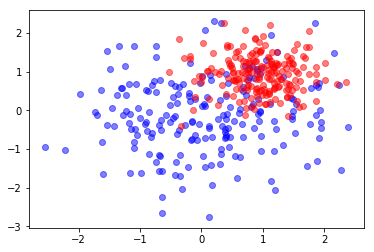

In [72]:
plt.scatter(X1[:,0], X1[:,1], alpha=.5, c='b')
plt.scatter(X2[:,0], X2[:,1], alpha=.5, c='r')
plt.show()

In [132]:
mu01  = random_choice(X)
cov01 = np.cov(X.T)

mu02  = random_choice(X)
cov02 = np.cov(X.T)

print 'initial guesses'
print 'mu01:  {0}\ncov01: {1}'.format(mu01, cov01)
print '\nmu02:  {0}\ncov02: {1}'.format(mu02, cov02)

initial guesses
mu01:  [ 0.95703462  1.51720494]
cov01: [[ 0.84827923  0.26456369]
 [ 0.26456369  0.84797968]]

mu02:  [ 0.97663904 -1.06001582]
cov02: [[ 0.84827923  0.26456369]
 [ 0.26456369  0.84797968]]


In [133]:
tau = np.random.rand(*X.shape)
tau = tau / tau.sum(1)[:, np.newaxis]
tau[:5]

array([[ 0.52945557,  0.47054443],
       [ 0.28827001,  0.71172999],
       [ 0.51075656,  0.48924344],
       [ 0.82684324,  0.17315676],
       [ 0.68782731,  0.31217269]])

In [158]:
_, p = X.shape
# e-step

prc_chol = compute_prec_chol(cov01)
log_det  = np.log(prc_chol.reshape(1, -1)[:,::p+1]).sum()
mahalanobis = compute_mahalanobis(X, mu01, prc_chol)

tau01 = -p*.5*np.log(2 * np.pi) + log_det -.5*mahalanobis

prc_chol = compute_prec_chol(cov02)
log_det  = np.log(prc_chol.reshape(1, -1)[:,::p+1]).sum()
mahalanobis = compute_mahalanobis(X, mu02, prc_chol)

tau02 = -p*.5*np.log(2 * np.pi) + log_det -.5*mahalanobis

tau = np.c_[tau01, tau02] + np.log(tau.sum(axis=0))

log_resp = tau - logsumexp(tau, axis=1)[:, np.newaxis]
print log_resp[:10]

[[-2.3759527  -0.09753115]
 [-0.89709154 -0.52383298]
 [-0.02907126 -3.55250566]
 [-0.41459453 -1.08059974]
 [-0.30884525 -1.32536634]
 [-3.56929003 -0.02858041]
 [-0.81978741 -0.58075697]
 [-1.67117371 -0.20828727]
 [-0.13670755 -2.05748651]
 [-0.64813997 -0.7402759 ]]


In [115]:
tau  = np.exp(log_resp)
mu01 = np.dot(tau[:,0], X) / np.sum(tau, 0)[:, np.newaxis][0]
mu02 = np.dot(tau[:,1], X) / np.sum(tau, 0)[:, np.newaxis][1]

diff = X - mu01
cov01 = np.dot(tau[:, 0] * diff.T, diff) / np.sum(tau, 0)[:, np.newaxis][0]

diff = X - mu02
cov02 = np.dot(tau[:, 1] * diff.T, diff) / np.sum(tau, 0)[:, np.newaxis][1]

print 'mu01:  {0}\ncov01: {1}'.format(mu01, cov01)
print '\nmu02:  {0}\ncov02: {1}'.format(mu02, cov02)

[[-2.95511119 -0.05347765]
 [-1.31068269 -0.31421212]
 [-0.05355118 -2.95377358]
 [-0.67197947 -0.71477267]
 [-0.51570578 -0.90901487]
 [-4.17934849 -0.01542686]
 [-1.21445741 -0.35221497]
 [-2.20314401 -0.11704556]
 [-0.24153002 -1.53909698]
 [-0.99353376 -0.46245769]]
mu01:  [ 0.5304561   0.84848614]
cov01: [[ 0.79401367  0.19638268]
 [ 0.19638268  0.36941055]]

mu02:  [ 0.46765305 -0.42491439]
cov02: [[ 0.94072667  0.3376388 ]
 [ 0.3376388   0.67825639]]


In [76]:
def compute_prec_chol(cov):
    _, p = np.array(cov).shape
    cov_chol = cholesky(cov, lower=True)
    return solve_triangular(cov_chol, np.eye(p), lower=True).T

In [40]:
def compute_precs_chol(covs):
    _, p, p = np.array(covs).shape
    precs_chol = np.empty((n_components, p, p))
    for k, cov in enumerate(covs):
        cov_chol = cholesky(cov, lower=True)
        precs_chol[k] = solve_triangular(cov_chol, np.eye(p), lower=True).T
    return precs_chol

In [167]:
def e_step(X, tau, mus, covs):
    n_samples, p = X.shape
    
    prc_chols = compute_precs_chol(covs)
    log_det = np.log(prc_chols.reshape(n_components, -1)[:,::p+1]).sum(axis=1)
    
    log_prob = np.empty((n_samples, n_components))
    for k, (mu, prc_chol) in enumerate(zip(mus, prc_chols)):
        log_prob[:, k] = compute_mahalanobis(X, mu, prc_chol)

    weighted_log = .5*(-p * np.log(2 * np.pi) - log_prob) + log_det + np.log(tau.sum(axis=0))
    log_resp = weighted_log - logsumexp(weighted_log, axis=1)[:, np.newaxis]
    
    return log_resp

In [185]:
n_components = 2
mu  = np.c_[random_choice(X), random_choice(X)].T
cov = np.r_[np.cov(X.T), np.cov(X.T)].reshape(2, 2, -1)

tau = np.random.rand(*X.shape)
tau = tau / tau.sum(1)[:, np.newaxis]
tau[:5]

array([[ 0.64274563,  0.35725437],
       [ 0.74005184,  0.25994816],
       [ 0.59288973,  0.40711027],
       [ 0.86452541,  0.13547459],
       [ 0.81889431,  0.18110569]])

In [186]:
print 'initial guesses'
print 'mu:  {0}\ncov: {1}'.format(mu, cov)

initial guesses
mu:  [[ 0.61407937 -0.0616264 ]
 [ 0.92085882  0.28044171]]
cov: [[[ 0.84827923  0.26456369]
  [ 0.26456369  0.84797968]]

 [[ 0.84827923  0.26456369]
  [ 0.26456369  0.84797968]]]


In [187]:
_, p = X.shape
bottom = -np.inf

l = []
for _ in range(100):
    prev = bottom
    
    log_resp = e_step(X, tau, mu, cov)
    tau = np.exp(log_resp)
    
    mu = np.dot(tau.T, X) / np.sum(tau, 0)[:, np.newaxis]
    pi = np.sum(tau, 0)[:, np.newaxis]
    cov = np.empty((n_components, p, p))
    for k, _ in enumerate(mu):
        diff = X - _
        cov[k] = np.dot(tau[:, k] * diff.T, diff) / pi[k]
        
    bottom = np.mean(log_resp)
    l.append(bottom)
    if abs(bottom - prev) < 1e-4:
        break

In [188]:
print 'mu:  {0}\ncov: {1}'.format(mu, cov)

mu:  [[-0.06177309 -0.13892431]
 [ 1.03817953  0.90761533]]
cov: [[[ 0.88068705 -0.00958111]
  [-0.00958111  0.88970461]]

 [[ 0.23148778 -0.03641   ]
  [-0.03641     0.27774414]]]


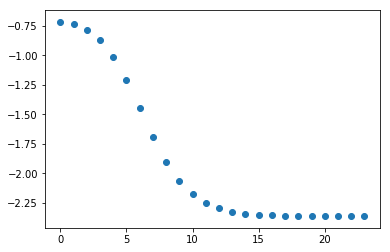

In [189]:
arr = range(len(l))
plt.scatter(arr, l)
plt.show()

In [65]:
pi = np.sum(tau, 0)[:, np.newaxis]
cov = np.empty((n_components, p, p))
for k, _ in enumerate(mu):
    diff = X - _
    cov[k] = np.dot(tau[:, k] * diff.T, diff) / pi[k]

array([[[ 1.01054513,  0.47615685],
        [ 0.47615685,  1.16489456]],

       [[ 0.91478118,  0.42780149],
        [ 0.42780149,  1.14416135]]])